# Controllable Text Summarization via Prompt Injection

# This file is a template for the different model inferences.

Guiding LLMs to generate summaries of specific lengths and format (e.g., five sentences, 280 words, bullet list) poses a considerable challenge. This study seeks to experiment with prompt injection strategies aimed at directing LLMs towards fulfilling user-requested summary accurately.

Prompt injection is a technique that involves adding a prompt to the input of a language model to guide its output. The prompt can be a sentence, a paragraph, or a set of instructions that the model should follow. In this study, we will experiment with different prompt injection strategies to guide the model to generate summaries of specific lengths and formats.

We mainly focus on the following prompt injection strategies:

Reasoning-based prompts: 
-   Generate a text {10-20-30} times shorter
-   Generate a text of length e•ln^2 w.r.t. the number of words in the document

Instruction-based prompts:
-   Generate a summary of {50-75-100-125-150-175-200} words
-   Generate a 1-sentence summary
-   Generate a bullet point of 3-5-10 items summarizing the document

## Code that should be modified for each model will be marked with a comment like this:
- /*********************************/
- #***MODIFY THIS FOR EACH MODEL***
- /**********************************/

#### Imports and library installs:

In [1]:
!pip install wandb
# *************************************
# For some models the following libraries gave us errors so we recommend to check the huggingface documentation for the latest installation instructions for each model.
!pip3 install --upgrade transformers optimum
# If using PyTorch 2.1 + CUDA 12.x:
!pip3 install --upgrade auto-gptq

  Obtaining dependency information for optimum from https://files.pythonhosted.org/packages/5d/7a/1cc655edf289cdb533b0ea1d2f382d344248a53ad21eb8e34deb4551684b/optimum-1.17.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/407.1 kB ? eta -:--:--
   - -------------------------------------- 10.2/407.1 kB ? eta -:--:--
   ---------------- ----------------------- 163.8/407.1 kB 2.5 MB/s eta 0:00:01
   ---------------------------------------- 407.1/407.1 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: optimum
    Found existing installation: optimum 1.17.0
    Uninstalling optimum-1.17.0:
      Successfully uninstalled optimum-1.17.0
  Obtaining dependency information for auto-gptq from https://files.pythonhosted.org/packages/c5/3f/4f93c1d136f07338feac4c4f457a1a9f5defe3b1af347d7caf31accddc0a/auto_gptq-0.7.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for gekko from https://files.pythonhosted.org/packages/57/d1/cdb977d024b2d7212bea0d6aa939df

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import pandas as pd
import wandb
import math
import transformers
import re

### Dataset loading:

In case you have a dataset file named 'pubmed.pkl' not in the current directory, please change the path accordingly. The dataset file should be a pickle file.

In [2]:
# Load dataset from file 
with open('pubmed.pkl', 'rb') as f: 
    dataset = pickle.load(f)

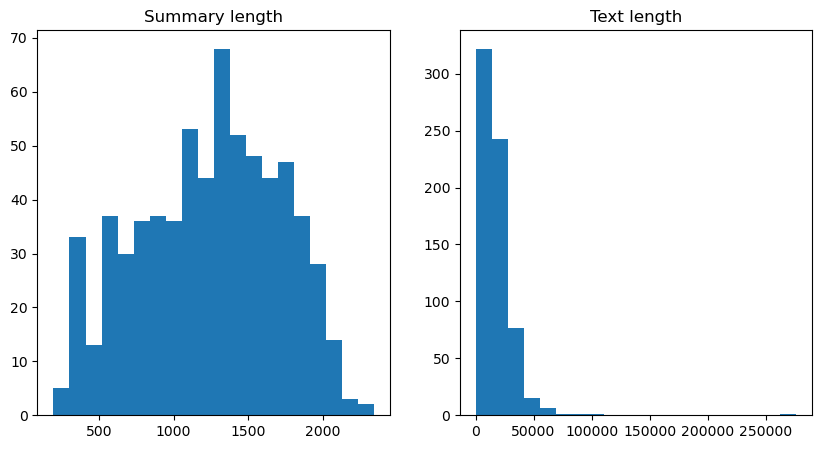

In [3]:
# Plot the length of each summary and of each text in two separate histograms as subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist([len(x) for x in dataset['summary']], bins=20)
axs[0].set_title('Summary length')
axs[1].hist([len(x) for x in dataset['document']], bins=20)
axs[1].set_title('Text length')
plt.show()

### Prompt definitions:

Here we define some example prompts which we use for one-shot inference:

In [4]:
prompt_example_text = "The impact of climate change on global weather patterns has become increasingly evident in recent years, with more frequent and intense storms, heatwaves, and wildfires being reported across the world. Scientists warn that without immediate and concerted efforts to reduce greenhouse gas emissions and mitigate the effects of climate change, these extreme weather events will only become more severe, posing significant risks to human societies, economies, and ecosystems."
prompt_example_summary_one_sentence = "Climate change is causing more extreme weather events worldwide, and urgent action is needed to reduce greenhouse gas emissions and mitigate its impacts to prevent further escalation of risks to society, economies, and ecosystems."
prompt_example_summary_3_bullet = "Automation and AI advancements are transforming the job market, raising worries about job displacement. Proponents highlight the potential for increased productivity, innovation, and the emergence of new job sectors. Successful adaptation requires investment in retraining programs, lifelong learning, and supportive policies for workers transitioning to new roles."
prompt_example_text_10_percent = "In recent years, advances in renewable energy technologies have significantly expanded the options for generating clean and sustainable electricity. Solar photovoltaic (PV) panels, wind turbines, and hydroelectric power plants are among the most widely adopted renewable energy sources, offering environmentally friendly alternatives to fossil fuels. These technologies harness natural resources like sunlight, wind, and water to produce electricity without emitting greenhouse gases or other harmful pollutants. As a result, renewable energy has emerged as a key solution to mitigating climate change and reducing dependence on finite fossil fuel resources. Moreover, the declining costs of renewable energy systems have made them increasingly competitive with traditional energy sources, driving widespread adoption and investment in renewable energy infrastructure worldwide."
prompt_example_summary_10_percent = "Renewable energy technologies like solar, wind, and hydro are gaining traction as clean alternatives to fossil fuels, offering environmentally friendly electricity generation without greenhouse gas emissions."

Below are the prompts used for zero-shot inference, both the "reasoning-based" and "instruction-based" prompts:

- prompts_before: These are the prompts that are used to guide the model to generate a summary of a specific length or format and are put before the document.
- prompts_after: These are the prompts that are put after the document.

Prompts before are defined as a dictionary with the following elements:
- key (str): The prompt name
- value (dict): The prompt dictionary with the following elements:
    - prompt_type (str): The prompt type. It can be 'percent', 'lenght', 'sentence' or 'bullet'
    - value (int): A value that is used by the corresponding prompt type check function. Changes meaning depending on the prompt type.

In [7]:
prompts_before = {
                'Generate a summary 10 times shorter for the following text: ' : {"prompt_type" : "percent", "value" : 10},
                'Generate a summary 20 times shorter for the following text: ' : {"prompt_type" : "percent", "value" : 20},
                'Generate a summary 30 times shorter for the following text: ' : {"prompt_type" : "percent", "value" : 30},
                'Generate a summary of lenght 50 words: ' : {"prompt_type" : "length", "value" : 50},
                'Generate a summary of lenght 75 words: ' : {"prompt_type" : "length", "value" : 75},
                'Generate a summary of lenght 100 words: ' : {"prompt_type" : "length", "value" : 100},
                'Generate a summary of lenght 125 words: ' : {"prompt_type" : "length", "value" : 125},
                'Generate a summary of lenght 150 words: ' : {"prompt_type" : "length", "value" : 150},
                'Generate a summary of lenght 175 words: ' : {"prompt_type" : "length", "value" : 175},
                'Generate a summary of lenght 200 words: ' : {"prompt_type" : "length", "value" : 200},
                'Summarise this text in 1 sentence: ' : {"prompt_type" : "sentence", "value" : 1},
                'Summarise this text in 5 sentences: ' : {"prompt_type" : "sentence", "value" : 5},
                'Summarise this text in 10 sentences: ' : {"prompt_type" : "sentence", "value" : 10},
                'Summarise this text in 3 bullet-points: ' : {"prompt_type" : "bullet", "value" : 3},
                'Summarise this text in 5 bullet-points: ' : {"prompt_type" : "bullet", "value" : 5},
                'Summarise this text in 10 bullet-points: ' : {"prompt_type" : "bullet", "value" : 10},
                'Summarise this text in 1 sentence.\n Text: ' : {"prompt_type" : "sentence", "value" : 1},
                'Summarise this text in 5 sentences.\n Text: ' : {"prompt_type" : "sentence", "value" : 5},
                'Summarise this text in 10 sentences.\n Text: ' : {"prompt_type" : "sentence", "value" : 10}
                # ****************************************
                # To add more prompts, use the following format:
                # 'Prompt: ' : {"prompt_type" : "type", "value" : value},
                # ****************************************
                }

prompts_after = [' Summary: ',
                 ' Example summary: '
                ]

### Data Preprocessing:

Tokenization using nltk library:

In [8]:
# Tokenize the documents and summaries
nltk.download('punkt')
tokenized_dataframe = pd.DataFrame()
tokenized_dataframe['summary'] = dataset['summary'].apply(word_tokenize)
tokenized_dataframe['document'] = dataset['document'].apply(word_tokenize)
tokenized_dataframe['document_len'] = tokenized_dataframe['document'].apply(len)
tokenized_dataframe['original_summary'] = dataset['summary']
tokenized_dataframe['original_document'] = dataset['document']

tokenized_dataframe.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ciprian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,summary,document,document_len,original_summary,original_document
0,"[we, determined, the, extent, and, distributio...","[survival, rates, continue, to, improve, with,...",2042,we determined the extent and distribution of c...,survival rates continue to improve with the ad...
1,"[methodsstudents, attending, five, different, ...","[for, every, living, creature, ,, elderliness,...",2535,methodsstudents attending five different types...,"for every living creature , elderliness is the..."
2,"[the, voltage, -, gated, k, channel, database,...","[voltage, -, gated, k, channels, (, vkcs, ), c...",2482,the voltage - gated k channel database ( vkcdb...,voltage - gated k channels ( vkcs ) constitute...
3,"[variations, in, quantity, and, quality, of, e...","[medicinal, plants, have, been, used, for, cen...",2561,variations in quantity and quality of essentia...,medicinal plants have been used for centuries ...
4,"[aim, ., acute, pancreatitis, is, an, inflamma...","[acute, pancreatitis, is, an, inflammatory, in...",3080,aim . acute pancreatitis is an inflammatory in...,acute pancreatitis is an inflammatory intra - ...


In [9]:
print("Number of documents: ", len(tokenized_dataframe))

Number of documents:  667


Filtering based on max context length for the model:

model_max_context_length is a dictionary that contains the maximum length of the input that the model can handle. It is defined as a dictionary with the following elements:
- key (str): The model name
- value (int): The maximum length of the input that the model can handle.

In [10]:
#**************************************************
model_max_context_length = {"llama2-chat": 4096,
                            "notus-7b": 2048}
model = "notus-7b"
#***If the model has a different max context length, add it to the dictionary and also change the model name***
#**************************************************
max_prompt_length = max([len(x) for x in prompts_before]) + max([len(x) for x in prompts_after])

We exclude documents which are too long for the model at hand and could generate errors by truncation.

In [11]:
max_context_length = model_max_context_length[model] - max_prompt_length

# Filter out documents that are too long
tokenized_dataframe = tokenized_dataframe[tokenized_dataframe['document_len'] <= max_context_length]

tokenized_dataframe.head()

,summary,document,document_len,original_summary,original_document
22,"[there, are, many, therapies, available, for, ...","[low, -, grade, lymphomas, are, chronic, disea...",1934,there are many therapies available for the man...,"low - grade lymphomas are chronic diseases , a..."
30,"[purpose, the, purpose, of, this, study, was, ...","[desktop, computer, and, laptop, use, is, beco...",1894,purpose the purpose of this study was to compa...,desktop computer and laptop use is becoming co...
34,"[background, :, varicose, vein, surgery, is, c...","[recurrence, has, been, attributed, to, neovas...",1875,background : varicose vein surgery is characte...,recurrence has been attributed to neovasculari...
47,"[neuroendocrine, tumors, are, a, heterogeneous...","[neuroendocrine, tumors, (, nets, ), comprise,...",1873,neuroendocrine tumors are a heterogeneous grou...,neuroendocrine tumors ( nets ) comprise a hete...
48,"[large, variation, in, assay, performance, and...","[in, the, aging, population, the, number, of, ...",1965,large variation in assay performance and outco...,in the aging population the number of alzheime...


In [12]:
print(f"Number of documents after filtering: {len(tokenized_dataframe)}")

Number of documents after filtering: 235


Remove from the dataframe rows in which the length of the summary is greater than the length of the document

In [13]:
# remove from the dataframe rows in which the length of the summary is greater than the length of the document
def sanitize(df):
    df = df[df['original_summary'].apply(len) <= df['original_document'].apply(len)]
    return df 

In [14]:
tokenized_dataframe = sanitize(tokenized_dataframe)

print(f"Number of documents after sanitizing: {len(tokenized_dataframe)}")

Number of documents after sanitizing: 230


Creating zero-shot and one-shot prompts based on the data and the prompts before and after

In [16]:
# This function is used to generate prompts for the model to generate an output on zero-shot inference and accepts the following parameters:
# data: the row of the dataframe containing the document and the summary
# special_tokens: the special tokens of the model
# prompt_before: the prompt to be used before the document
# prompt_after: the prompt to be used after the document
# length_based: a boolean value that indicates if the prompt is length-based or not
# The function returns a dictionary containing the prompt, the document, the summary, the type of prompt, the value of the prompt and the prompt_before used
def prompt_creation_zero_shot(data, special_tokens, prompt_before, prompt_after, length_based=False):
    document = data['original_document']
    summary = data['original_summary']
    doc_len = data['document_len']
    
    if length_based:
        # Length-based prompts are used to generate summaries of different lengths = exln^2
        size = math.ceil(math.exp(1) * (math.pow(math.log(doc_len), 2)))
        text = f"Generate a summary of length e*(ln^2): "
        prompt = f"{special_tokens}{text}{document}{prompt_after}{special_tokens}"
        return {"prompt": prompt, "document": document, "summary": summary, "prompt_type": "lenght", "value": size, "prompt_before": prompt_before}
    
    prompt_type = prompts_before[prompt_before]["prompt_type"]
    value = prompts_before[prompt_before]["value"]
    prompt = f"{special_tokens}{prompt_before}{document}{prompts_after}{special_tokens}"
    return {"prompt": prompt, "document": document, "summary": summary, "prompt_type": prompt_type, "value": value, "prompt_before": prompt_before}

# This function is used to generate prompts for the model to generate an output on one-shot inference and accepts the following parameters:
# data: the row of the dataframe containing the document and the summary
# special_tokens: the special tokens of the model
# prompt_before: the prompt to be used before the document
# prompt_after: the prompt to be used after the document
# type_of_prompt: the type of prompt to be used, which can be "ten percent", "one sentence" or "three bullet"

def prompt_creation_one_shot(data, special_tokens, prompt_before, prompt_after, type_of_prompt):
    document = data['original_document']
    example_after_text = prompts_after[1]
    if type_of_prompt == "ten percent":
        prompt = f"{special_tokens}{prompt_before}{prompt_example_text_10_percent}{example_after_text}{prompt_example_summary_10_percent}{prompt_before}{document}{prompt_after}{special_tokens}"
        return prompt, type_of_prompt
    if type_of_prompt == "one sentence":
        prompt = f"{special_tokens}{prompt_before}{prompt_example_text}{example_after_text}{prompt_example_summary_one_sentence}{prompt_before}{document}{prompt_after}{special_tokens}"
        return prompt, type_of_prompt
    if type_of_prompt == "three bullet":
        prompt = f"{special_tokens}{prompt_before}{prompt_example_text}{example_after_text}{prompt_example_summary_3_bullet}{prompt_before}{document}{prompt_after}{special_tokens}"
        return prompt, type_of_prompt
    return prompt, type_of_prompt

In [17]:
prompt_creation_zero_shot(tokenized_dataframe.iloc[0], "", "Generate a summary 10 times shorter for the following text: ", " Summary: ", length_based=False)

{'prompt': "Generate a summary 10 times shorter for the following text: low - grade lymphomas are chronic diseases , and some patients may live for many years following initial diagnosis.1 therefore , for many patients it is currently regarded as appropriate not to treat immediately at diagnosis , but rather to watch and wait . once patients do require treatment , there are many therapies available : chemotherapeutic agents known to be effective in low - grade lymphoma include alkylating agents , anthracycline - based regimens , purine analogs , and bendamustine . in addition , there is the established monoclonal antibody therapy rituximab , and newer antibodies such as ofatumumab . patients may also undergo stem - cell transplantation either autologous or allogeneic with or without myeloablation preceding allogeneic transplantation . finally , there is currently a small amount of experience available on the use of techniques such as dna vaccination or antisense therapy . questions abo

In [18]:
prompt_creation_one_shot(tokenized_dataframe.iloc[0], "", "Summarise this text in 1 sentence.\n Text: ", " Summary: ", "one sentence")

('Summarise this text in 1 sentence.\n Text: The impact of climate change on global weather patterns has become increasingly evident in recent years, with more frequent and intense storms, heatwaves, and wildfires being reported across the world. Scientists warn that without immediate and concerted efforts to reduce greenhouse gas emissions and mitigate the effects of climate change, these extreme weather events will only become more severe, posing significant risks to human societies, economies, and ecosystems. Example summary: Climate change is causing more extreme weather events worldwide, and urgent action is needed to reduce greenhouse gas emissions and mitigate its impacts to prevent further escalation of risks to society, economies, and ecosystems.Summarise this text in 1 sentence.\n Text: low - grade lymphomas are chronic diseases , and some patients may live for many years following initial diagnosis.1 therefore , for many patients it is currently regarded as appropriate not t

### Connection to WandB:

##### YOUR_API_KEY should be replaced by the personal API key obtainable on Wandb. The code should be then uncommented.

In [17]:
# *******************************
# ***Here you should add the personal api key from wandb, it can be found in the profile settings page***
# *******************************
#wandb.login(key='YOUR_API_KEY')

In [18]:
# *******************************
# ***Change project variable to the name of the table you want to create on wandb***
# *******************************
run = wandb.init(project="table-test")

# *******************************
# ***Change the columns variable to the columns you want to add to the table***
# *******************************
my_table = wandb.Table(columns=["Model", "Prompt", "Output", "Percent check", "Percent", "Words check", "Words", "Sentences check", "Sentences", "BART score"])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cipdev16 (deep-mining-project). Use `wandb login --relogin` to force relogin


### Metric definitions:

We created ad hoc criteria to assess the correctness of the generated summaries. Specifically, we use NLTK word_tokenize to check the output length and compare it to the input length, following the instruction given.

We used a margin not to be overly specific and allow for small disalignments from the precise expected lengt

In [19]:
def percent_check(input, output, percent):
    tokenized_input = word_tokenize(input)
    tokenized_output = word_tokenize(output)
    if len(tokenized_output) <= (1/percent)*len(tokenized_input) + 3 and len(tokenized_output) >= (1/percent)*len(tokenized_input) - 3:
        return True, len(tokenized_output)*100/len(tokenized_input)
    return False, len(tokenized_output)*100/len(tokenized_input)

def length_check(output, length):
    tokenized_output = word_tokenize(output)
    if len(tokenized_output) <= length + 10 and len(tokenized_output) >= length + 10:
        return True, len(tokenized_output)
    return False, len(tokenized_output)

def sentence_check(output, sentence_length):
    # remove bullet points and new lines from the output
    output = output.replace("\n", "")
    regex = re.compile(r'^\d+\.\s*')
    print(output)
    tokenized_output = sent_tokenize(output)
    filtered = [i for i in tokenized_output if not regex.match(i)]
    if len(filtered) == sentence_length:
        return True, len(filtered)
    return False, len(filtered)

def bullet_check(output, bullet_length):
    tokenized_output = output.split("\n")
    # remove empty strings from the list
    tokenized_output = list(filter(None, tokenized_output))
    print(tokenized_output)
    if len(tokenized_output) == bullet_length:
        return True, len(tokenized_output)
    return False, len(tokenized_output)

Furthermore, we should also test the quality of the generated summaries. As we cannot rely on a target summary, we selected BARTScore to evaluate the factualness and semantic similarity of the predicted summary against the source document.

In [39]:
from bart_score import BARTScorer

scorer = BARTScorer()
# scorer.load(path="bart_score.pth")

def calculate_bart_score(hypotheses, references):
    score = scorer.score(references, hypotheses)
    return score


In [27]:
calculate_bart_score(["The quick brown fox jumps over the lazy dog"], ["The quick brown fox jumps over the lazy dog"])

[-1.0009068250656128]

### Testing setup: 

Here we define the testing setup for the experiment: what models we use, what prompts we use, and what documents we use.

In [25]:
# define random seed
seed = 42
np.random.seed(seed)

# choose n random documents from the dataset where n is the number of prompts
n = len(prompts_before)
random_docs = tokenized_dataframe.sample(n)

# create a list of prompts for zero-shot inference
zero_shot_prompts = []
for i in range(n):
    for j in range(len(prompts_after) - 1):
        zero_shot_prompts.append(prompt_creation_zero_shot(random_docs.iloc[i], "", i, j, length_based=False))
zero_shot_prompts.append(prompt_creation_zero_shot(random_docs.iloc[0], "", 0, 0, length_based=True))

# create a list of prompts for one-shot inference
one_shot_prompts = []
one_shot_prompts.append(prompt_creation_one_shot(random_docs.iloc[0], "", 0, 1, ten_percent=True, one_sentence=False, three_bullet=False))
one_shot_prompts.append(prompt_creation_one_shot(random_docs.iloc[0], "", 0, 1, ten_percent=False, one_sentence=True, three_bullet=False))
one_shot_prompts.append(prompt_creation_one_shot(random_docs.iloc[0], "", 0, 1, ten_percent=False, one_sentence=False, three_bullet=True))

print("Zero-shot prompts: ", zero_shot_prompts)
print("One-shot prompts: ", one_shot_prompts)

Size:  154
Size:  154
Zero-shot prompts:  [['Generate a summary 10 times shorter for the following text: a 16-month old , baby girl , weighing 9.5 kg and measuring 74 cm , visited the hospital because of a cough . in a chest radiograph done under the suspicion of an upper respiratory infection , a round foreign object with a diameter of 21 mm was detected in the upper esophagus ( fig . 1 ) . in a sleep endoscopy , it was confirmed to be a circular battery ( fig . 2 ) , and ingestion was estimated to occur three days prior to the hospital visit , and it was determined that endoscopic removal would not be easy . the infant had no underlying disease , and glycopyrrolate 0.05 mg was i m injected 30 minutes before arriving at the operating room as premedication for the anesthesia . the infant was monitored by ecg , non - invasive blood pressure ( nibp ) , and a pulse oximetry , and before anesthesia , her blood pressure was 8561 mmhg ; her heart rate was 160 beats min with 100 oxygen satura

We infer the summaries one by one, given a model, possibly its tokenizer, the data and the prompt.

We then upload the results on wandb using multiple metrics matching the specific prompt request.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
# Load the model and tokenizer
model_name_or_path = "TheBloke/notus-7B-v1-GPTQ"
# To use a different branch, change revision
# For example: revision="gptq-4bit-32g-actorder_True"
model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             revision="main")

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

for i in range(n * (len(prompts_after) - 1) + 1):
    # prepare the prompt for the model and the summary for the Bart score
    prompt = zero_shot_prompts[i]["prompt"]
    prompt_type = zero_shot_prompts[i]["prompt_type"]
    size = zero_shot_prompts[i]["size"]
    document = zero_shot_prompts[i]["document"]
    summary = zero_shot_prompts[i]["summary"]
    prompt_template=f'''
    <|im_start|>user
    {prompt}<|im_end|>
    '''
    # infer the output and clean it from the special tokens
    input_ids = tokenizer(prompt_template, return_tensors='pt').input_ids.cuda()
    encoded_output = model.generate(inputs=input_ids, temperature=0.7, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=model_max_context_length["notus-7b"])
    decoded_output = tokenizer.decode(encoded_output[0])
    print(decoded_output)
    output = decoded_output.split("|im_end|>")[1]
    output = output.split("</s>")[0]
    output = output.split("\n", 1)[1]
    # based on the prompt type, check the output and add the results to the table
    if prompt_type < 3:
        if size != "na":
            check, length = length_check(output, size)
            bart_score = calculate_bart_score([output], [summary])
            my_table.add_data(model_name_or_path, prompt, output, None, None, check, length, None, None, bart_score[0])
            continue

        check , percent = percent_check(document, output, (prompt_type + 1)*10)
        bart_score = calculate_bart_score([output], [summary])
        my_table.add_data(model_name_or_path, prompt, output, check, percent, None, None, None, None, bart_score[0])
        continue
    if prompt_type >= 3 and prompt_type < 10:
        check , length = length_check(output, (prompt_type-2)*25)
        bart_score = calculate_bart_score([output], [summary])
        my_table.add_data(model_name_or_path, prompt, output, None, None, check, length, None, None, bart_score[0])
        continue
    if prompt_type == 10 or prompt_type == 16:
        check , length = sentence_check(output, 1)
        bart_score = calculate_bart_score([output], [summary])
        my_table.add_data(model_name_or_path, prompt, output, None, None, None, None, check, length, bart_score[0])
        continue
    if prompt_type == 11 or prompt_type == 17:
        check , length = sentence_check(output, 5)
        bart_score = calculate_bart_score([output], [summary])
        my_table.add_data(model_name_or_path, prompt, output, None, None, None, None, check, length, bart_score[0])
        continue
    if prompt_type == 12  or prompt_type == 18:
        check , length = sentence_check(output, 10)
        bart_score = calculate_bart_score([output], [summary])
        my_table.add_data(model_name_or_path, prompt, output, None, None, None, None, check, length, bart_score[0])
        continue
    if prompt_type == 13:
        check , length = bullet_check(output, 3)
        bart_score = calculate_bart_score([output], [summary])
        my_table.add_data(model_name_or_path, prompt, output, None, None, None, None, check, length, bart_score[0])
        continue
    if prompt_type == 14:
        check , length = bullet_check(output, 5)
        bart_score = calculate_bart_score([output], [summary])
        my_table.add_data(model_name_or_path, prompt, output, None, None, None, None, check, length, bart_score[0])
        continue
    if prompt_type == 15:
        check , length = bullet_check(output, 10)
        bart_score = calculate_bart_score([output], [summary])
        my_table.add_data(model_name_or_path, prompt, output, None, None, None, None, check, length, bart_score[0])
        continue


run.log({"Table Name": my_table})